*Please feel free to copy or reproduce any part of this notebook for non-commerical use with proper attribution*

# In this notebook...

In this notebook we:
- Learn about **AssemblyAI's Speech-to-Text API** and create a free account
- Use **URL requests** and **FFmpeg** to automatically download audio from iPhone 10 reviews on YouTube
- **Use AssemblyAI's API** to upload these audio files and receive **transcripts of the reviews**
- Learn about the **BERT model**
- Utilize **Hugging Face's model repo** to download a **pretrained BERT model**
- Use this BERT model to perform **review classification** to **determine public opinion on the iPhone 10**

Let's get started!

# Introduction

**AssemblyAI** is a SaaS company that provides **high-accuracy speech recognition with an easy-to-use API**. Let's sign up for a free account and dive in!

Navigate to AssemblyAI's website [here](https://www.assemblyai.com/) and select *Start now for free*.

<br /><br />

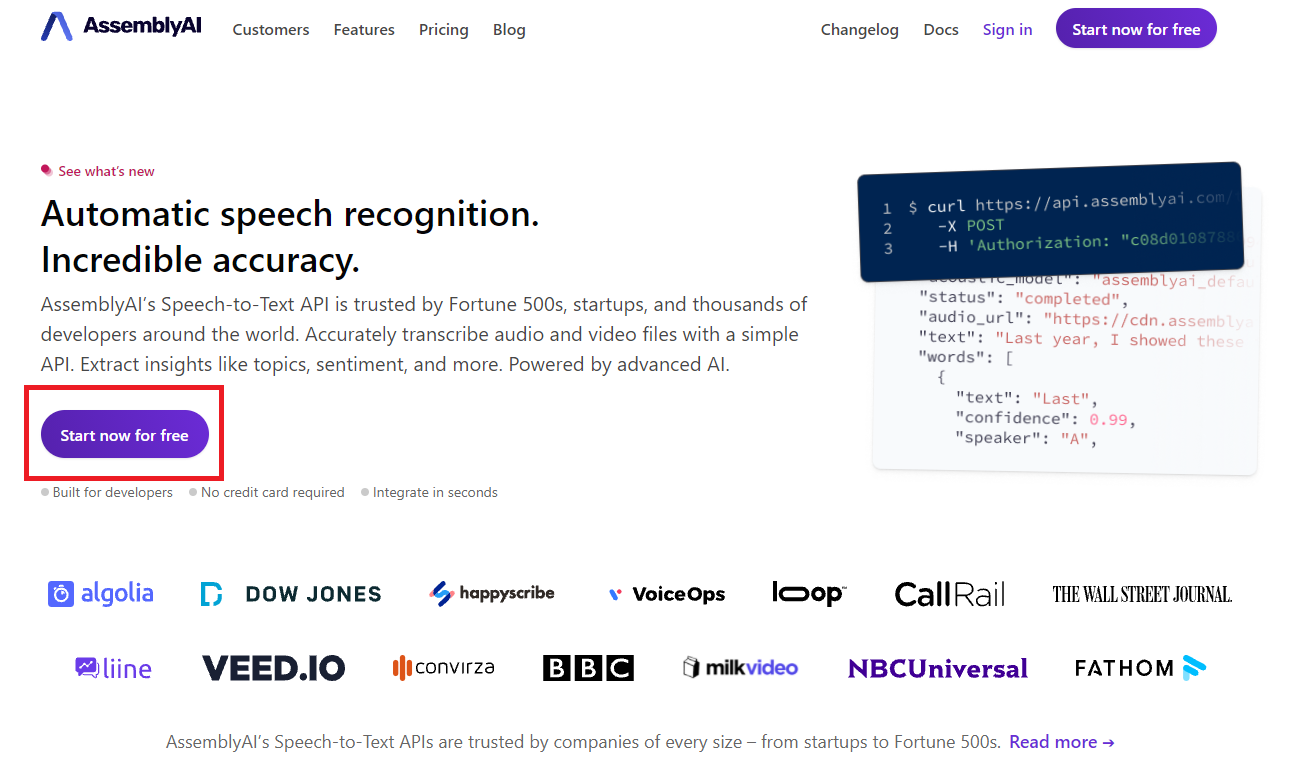
  
<br /><br />
  
Enter your email and create a new password, and you'll be directed to the below page. If you'd like, explore their page and check out their quickstart guide for more information. When you're ready, all we'll need is **Your API Key**, so go ahead and copy that into a Python variable
  
<br /><br />  
  
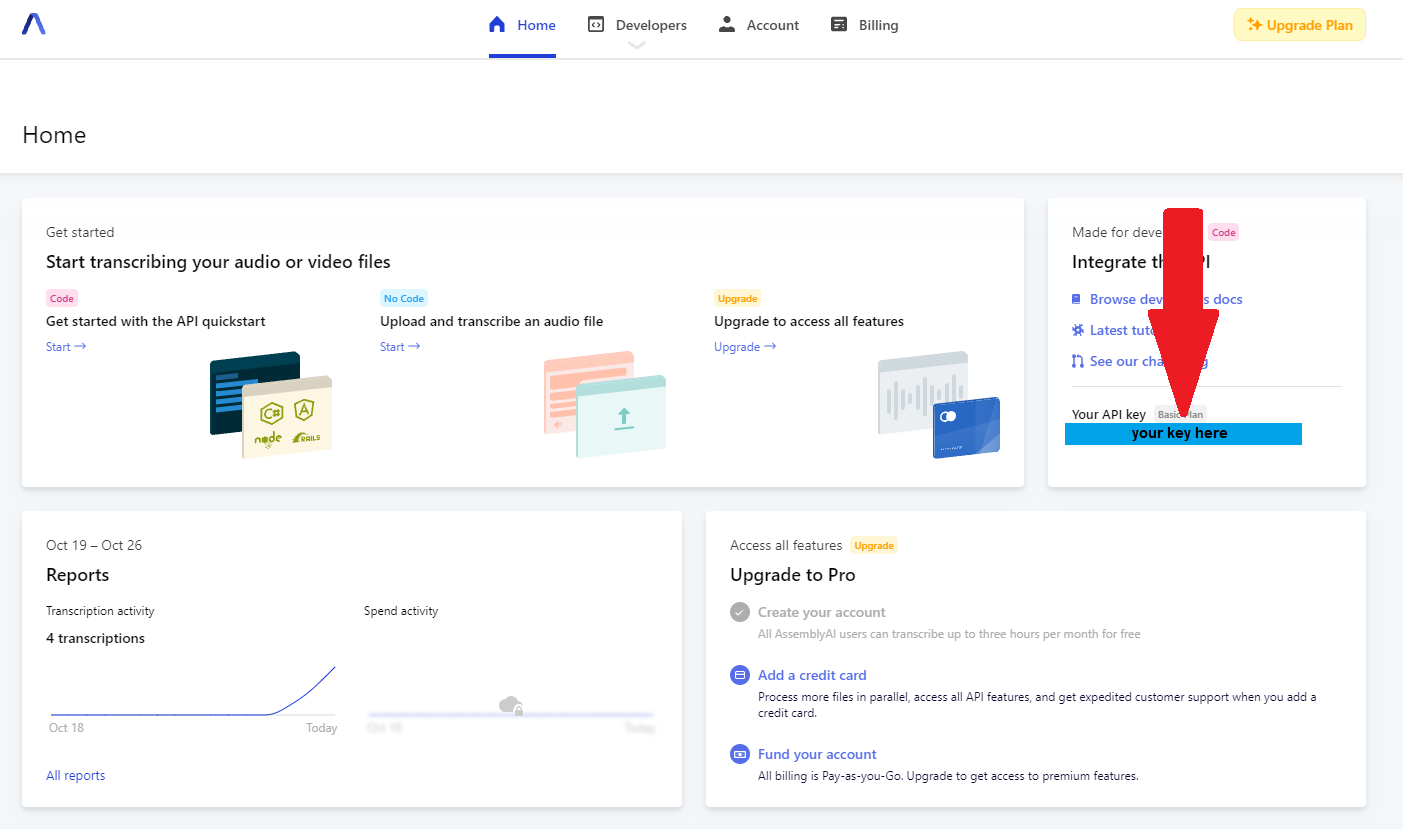

In [134]:
api_key = '<YOUR-KEY-HERE>'

# Imports

Next, make sure you're in a **virtualenv** with the following packages installed. If not, pip install each of them now.

In [135]:
import requests
import youtube_dl
import sys
import time
import json
import os
import urllib.request
from transformers import pipeline

# Using FFmpeg and Requests for Automatic Downloads

Before we can use AssemblyAI's API, we need some audio to upload! Let's assume the role of an analyst who wants to understand public sentiment regarding the iPhone 10. We'll automatically download the audio from the first *n* results when we search "iPhone 10 review".

### Set youtube download options

If you do not have FFmpeg, download it [here](https://www.ffmpeg.org/download.html). Just download the source code - we need the binary or executable file.

Now, let's set some download options. We set options to download in mp3 format using FFmpeg at the preferred quality. Make sure to replace the `ffmpeg_location` attribute with the path to your FFmpeg bin/exe if it is not on your PATH!

In [160]:
ydl_opts = {
    "format": "bestaudio/best",
    "postprocessors": [{
        "key": "FFmpegExtractAudio",
        "preferredcodec": "mp3",
        "preferredquality": "192",
    }],
    "ffmpeg_location": "C:\\<YOUR PATH> \\FFmpeg\\bin",
    "outtmpl": "./%(id)s.%(ext)s",
}

### Scrape Youtube URLs

Next, we're going to **scrape a list of YouTube URLs** that result from our desired query. You can change `search_keyword` to whatever you'd like. We then format the string properly for YouTube and prepend the necessary URL to the search. Change `num_to_get` to the desired number of videos you'd like to download the audio of - we have selected 3 here. The URLs are then saved in a list called `video_list`.

In [179]:
import urllib.request
import re

search_keyword="iphone 10 review"
search_keyword = search_keyword.replace(" ", "+")
html = urllib.request.urlopen("https://www.youtube.com/results?search_query=" + search_keyword)
video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())

video_list = []
num_to_get = 3
for i in range(min(num_to_get, len(video_ids))):
    url = "https://www.youtube.com/watch?v=" + video_ids[i]
    print(url)
    video_list.append(url)

https://www.youtube.com/watch?v=9Ca8zWJOlFQ
https://www.youtube.com/watch?v=KExKk4VomGo
https://www.youtube.com/watch?v=DpvhU2mXw4A


### Use the URLs and FFmpeg to download the audio

Next, we iterate through each of the URLs, downloading the audio at each step and saving a dictionary that stores the filename and video title.

In [180]:
def get_vid(_id):
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        return ydl.extract_info(_id)

In [181]:
mp3_files = []
for vid in video_list:
    try:
        vid.strip()
        meta = get_vid(vid)
        mp3_files.append({"id": meta["id"]+".mp3", "title": meta["title"]})
    except:
        print(vid, " could not be downloaded")

[youtube] 9Ca8zWJOlFQ: Downloading webpage
[download] Resuming download at byte 15166378
[download] 9Ca8zWJOlFQ.m4a has already been downloaded
[download] 100% of 14.46MiB
[ffmpeg] Correcting container in "9Ca8zWJOlFQ.m4a"
[ffmpeg] Destination: 9Ca8zWJOlFQ.mp3
Deleting original file 9Ca8zWJOlFQ.m4a (pass -k to keep)
[youtube] KExKk4VomGo: Downloading webpage
[download] Destination: KExKk4VomGo.m4a
[download] 100% of 11.98MiB in 03:38                  
[ffmpeg] Correcting container in "KExKk4VomGo.m4a"
[ffmpeg] Destination: KExKk4VomGo.mp3
Deleting original file KExKk4VomGo.m4a (pass -k to keep)
[youtube] DpvhU2mXw4A: Downloading webpage
[download] Destination: DpvhU2mXw4A.m4a
[download] 100% of 8.15MiB in 02:07                  
[ffmpeg] Correcting container in "DpvhU2mXw4A.m4a"
[ffmpeg] Destination: DpvhU2mXw4A.mp3
Deleting original file DpvhU2mXw4A.m4a (pass -k to keep)


In [182]:
mp3_files

[{'id': '9Ca8zWJOlFQ.mp3', 'title': 'Apple iPhone X Review: The Best Yet!'},
 {'id': 'KExKk4VomGo.mp3',
  'title': 'iPhone X in 2021 - Should You Still Buy It?'},
 {'id': 'DpvhU2mXw4A.mp3',
  'title': 'iPhone X: Is it Still Worth Buying in 2021?'}]

# Transcription with AssemblyAI

Now that we have the audio we need, we can finally move on to the fun part - **using AssemblyAI's API to transcribe the audio** and performing text classification to understand if reviews are positive or negative!

### Save endpoints and create JSON header

Let's save the API endpoints for uploads and transcripts, and prepare a JSON header for our POST and GET requests:

In [183]:
transcript_endpoint = "https://api.assemblyai.com/v2/transcript"
upload_endpoint = "https://api.assemblyai.com/v2/upload"

In [184]:
headers_auth_only = {"authorization": api_key}
headers = {
    "authorization": api_key,
    "content-type": "application/json"
}

### Upload to AssemblyAI

Now we are ready to upload the audio files to AssemblyAI!

In [185]:
def read_file(filename, chunk_size=5242880):
    with open(filename, "rb") as _file:
        while True:
            data = _file.read(chunk_size)
            if not data:
                break
            yield data

We upload the audio to AssemblyAI via a POST request, using the header we defined earlier, iterating through each file in our `mp3_files` list.

We save the JSON from the response in a new list called `upload_URLs`

In [186]:
upload_urls = []
for file in mp3_files:
    upload_response = requests.post(
        upload_endpoint,
        headers=headers_auth_only, data=read_file(file['id'])
    )
    upload_urls.append(upload_response.json())

### Request Transcript

Next, for each of our uploaded files (i.e. for each upload URL), we perform a POST request for its transcript. We once again save the JSON from the response into a new list, this time called `transcript_responses`.

We see that our requests have been queued.

In [187]:
transcript_responses = []
for response in upload_urls:
    transcript_request = {
        'audio_url': response['upload_url']
    }
    transcript_response = requests.post(transcript_endpoint, json=transcript_request, headers=headers)
    transcript_responses.append(transcript_response.json())
    
# Will be queued to have transcripts created
print(transcript_responses[0]['status'])

queued


### Wait until the transcript is received

In [193]:
while True:
    polling_endpoints = []
    for i in transcript_responses:
            polling_endpoint = "https://api.assemblyai.com/v2/transcript/" + i['id']
            polling_endpoints.append(polling_endpoint)


    polling_responses = []
    for i in polling_endpoints:   
        polling_response = requests.get(i, headers=headers)    
        polling_responses.append(polling_response.json())

    i = 0
    for response in polling_responses:
        if response['status'] == 'completed':
            i += 1
    
    print(i, 'of', len(polling_responses), 'transcriptions completed.')
    if i == len(polling_responses):
        break
    time.sleep(5)

3 of 3 transcriptions completed.


# Parsing the AssemblyAI Transcript

Now we can start using our transcripts! First, we perform a GET request using the `/paragraphs` and `/sentences` endpoints to **access the paragraphs and sentences** within each view respectively.

In [194]:
paragraphs_responses = []
sentences_responses = []

for i in polling_endpoints:
    paragraphs_responses.append(requests.get(i + "/paragraphs", headers=headers))
    sentences_responses.append(requests.get(i + "/sentences", headers=headers))

Next we **parse the JSON and save the text from the response**. We created two lists, `paragraphs` and `sentences`. Each element within these lists is another list that corresponds to a given review. In this case, we have three reviews so both `paragraphs` and `sentences`have length 3.  

Each review sublist contains either the paragraphs or sentences of the review as elements, so `paragraphs[0][1]` accesses the second paragraph of the first review.

In [195]:
paragraphs = []
sentences = []

for i in paragraphs_responses:
    paras = []
    for para in i.json()['paragraphs']:
        paras.append(para)
    paragraphs.append(paras)

for i in sentences_responses:
    sent = []
    for j in i.json()['sentences']:
        sent.append(j['text'])
    sentences.append(sent)

# Sentiment Analysis with BERT

Now we can move on to our final goal - attempting to understand public reception of the iPhone 10 by analyzing the sentiment of online reivews!

### BERT

[BERT](https://arxiv.org/abs/1810.04805), or Bidirectional Encoder Representations from Transformers, is a Transformer language model.  

Before the invention of Transformers, RNNs (and later LSTMs and GRUs) were commonly used for machine learning in domains of sequential data. While very powerful, any form of recurrent net by definition uses a recurrence relation. This means that **sequential processing of data is necessary and inevitable**. LSTMs and GRUs help alleviate other issues relating to maintaining long-term dependencies, but intrinsically suffer from similar issues.  

Transformers were introduced to **avoid recursion and allow for parallel processing** for faster train. Self-attention and positional embeddings were new innovations that allow for non-sequentiality and encoding information about the positions of tokens.  

### Using BERT as a Classifier

We can use the `transformers` package for extremely quick and easy sentiment analysis using a **pretrained BERT model**. Note that the general method here is to use a pretrained BERT model for feature extraction and then **finetune it for a downstream task** (or possibly in addition some BERT weights) in order to **tailor the model to a specific dataset**.  

Here, we are simply taking the pretrained model and using it directly for classification. While certainly not as accurate as the finetuning method, it is a quick-and-dirty approach that allows us to not have to worry about generating a labeled dataset for supervised training of a classifier.  

To get started, all we need to do is simply use the `pipeline()` method from the `transformers` package to download a model for our specified task of sentiment analysis. You can see more details about the model [here](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).

In [196]:
classifier = pipeline('sentiment-analysis');

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are 

### Classifying

Next, we go through each review and **count the total number of positive and negative sentences in each review**, saving a dictionary for each review in our `values` list.

In [201]:
pos_sent = []
neg_sent = []
num_to_save = 10

values = []
for review in sentences:
    pos = 0
    neg = 0
    r = classifier(review)
    for idx, label in enumerate(r):
        if label['label'] == 'POSITIVE':
            pos += 1
            if len(pos_sent) < num_to_save:
                pos_sent.append(review[idx])
        else:
            neg += 1
            if len(neg_sent) < num_to_save:
                neg_sent.append(review[idx])
                
    values.append({'pos':pos, 'neg':neg})

In [202]:
values

[{'pos': 101, 'neg': 114}, {'pos': 65, 'neg': 84}, {'pos': 56, 'neg': 44}]

In general, we see that we see more negative than positive sentiment. Let's take a look at some example of positively and negatively classified sentences to see how the model performed. Note that each of these sentences is from the first review (a generally "negative" review according to the model)

In [209]:
for idx, elt in enumerate(pos_sent):
    print(idx+1, ' ', elt)

1   Hey, what's up, guys?
2   I'm Kimbhd here, and this is iphone X, and it's my favorite iphone ever by far.
3   And there's no doubt that in the history of iphones, this thing is iconic.
4   It's more more modern.
5   It finally feels like a new iphone.
6   There's a learning curve to this phone.
7   Unlike any other iphone.
8   You know what you're getting yourself into.
9   You know exactly how to use it.
10   And you're good.


**Let's see how these sentences break down**
- Sentences 2 and 3 are explicitly positive  
- Sentences 4, 5, 7, 9, and 10 are very likely positive given the context, but *could* be framed as negative  
- Sentence 1 is neutral  
- Sentences 6 and 8 are likely negative given the context, but not explicitly so.

In [210]:
for idx, elt in enumerate(neg_sent):
    print(idx+1, ' ', elt)

1   That's a big part of why I like it so much, but that's also the source for a few sore spots.
2   You see, every other iphone ever has just been home button, rectangle screen, rounded corners, pretty much the same thing.
3   And if there's any one big new feature every year, it takes you 2 seconds to learn it.
4   It's very clearly still an iphone.
5   So on the outside, it's the shape we're used to the rectangle surrounded corners, but this is the first time the display itself actually has curved corners and it's pushed right up to the edges of the phone, or at least closer than they've ever been.
6   Phones have small bezels.
7   That forsaken notch at the top.
8   Just holding the phone, though.
9   Despite the larger display, the Ten is definitely closer to feeling like an iphone eight than an eight plus, it still feels like a smaller phone compared to the others I've used.
10   The silver, it's so shiny, and honestly, we all know your phone is never going to look as good as it 

**Let's see how these sentences break down**  
- Sentence 7 is are explicitly negative  
- Sentence 1 is mixed, but looks to be preceding negative comments.
- Sentence 4 is fairly neutral, potentially slightly negative
- Sentences 5, 6, and 8 are fairly neutral and/or descriptive
- Sentences 9 and 10 are fairly descriptive but possibly positive given the context
- Sentences 2 and 3 are likely positive given the context, but *could* be construed as negative

In general, we see that the classifier actually did surprisingly well. It appears that the addition of a "neutral" classification could help improve the model significantly so that it can be highly precise in its positive and negative classifications.

# Extensions

This is not an exhaustive project and serves merely to **highlight the ease with which AssemblyAI's API can be used to extract text**, as well as the ease of us for a Hugging Face pretrained BERT model.  

There are many extensions that one could perform in practice to help improve this technique. These include:
- **Scrape subscriber and view count** on the videos to give more weight to more popular reviews
- Plot a **histogram of non-stop words** for positive and negative reviews/sentences to get a better idea of the **good and bad features of the iPhone 10**
- Scrape a higher number of reviews and manually label sentiment for at least a few of them. Use this data to **fine-tune BERT for this specific task**
- Finetune the model on a **different but related review dataset** avaiable online
- AS said above, use a **model that includes a "neutral" classification** option so it can be more selective about what counts as positive or negative
- Try using VADER in place of BERT

And many more! Do you have any other ideas? Feel free to contact me on my website here and we can discuss

# Credit

- Information from [this](https://huggingface.co/transformers/) documentation was referenced in utilizing the pretrained BERT model for text classification
- Information from [this](https://stackoverflow.com/questions/50713219/getting-links-of-youtube-search-result) post was utilized in scraping YouTube URLs
- Information from [this]([https://www.youtube.com/watch?v=SmxEU_9ATTc&ab_channel=YujianTang}) video was utilized in using the AssemblyAI API